<h1><center>Kiara Koeppen Freight Cost Model</center></h1>

* Before aggregating the data in Python, I like to visualize the it in Tableau. I think Tableau is a quick and easy way to get some meaningful insight from the data.
* Specifically, I'm curious about the two columns with mixed data types indicated in the data dictionary. 

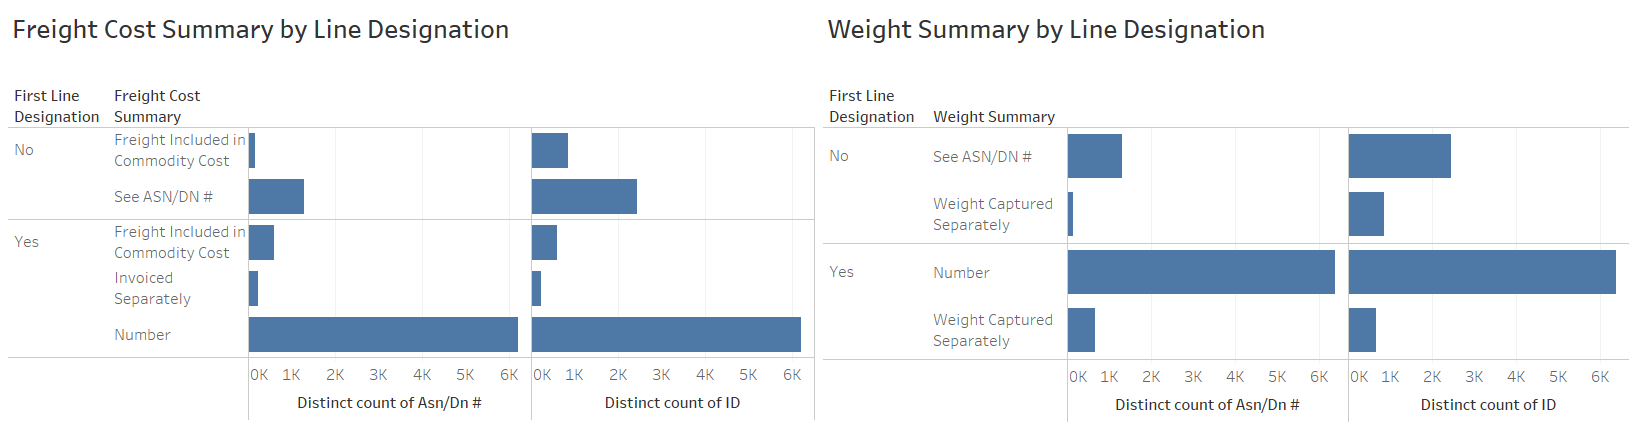

In [48]:
# Import packages
import sys
import pandas as pd
import os
import openpyxl as xl
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
from datetime import datetime 
import numpy as np 
import re
import csv
import pyodbc
import psycopg2
import scipy 
import sqlalchemy
from sqlalchemy import create_engine
from CoolProp.CoolProp import PropsSI
import CoolProp as CP
import time
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import RobustScaler
import math

import warnings
warnings.filterwarnings('ignore')


### Loading csv file

In [49]:
df=pd.read_csv(r'C:\Users\irifmw\Downloads\SCRATCH\SCMS_Delivery_History_Dataset.csv')
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,11667,151-NG-T01,Pre-PQ Process,SO-27816,DN-1350,Nigeria,PMO - US,From RDC,N/A - From RDC,Air Charter,...,30,149824,3932880.0,26.25,0.88,"Aspen-OSD, Port Elizabeth, SA",Yes,13037,7445.8,7708.44
1,83900,111-MZ-T30,FPQ-15195,SO-50140,DN-4191,Mozambique,PMO - US,From RDC,N/A - From RDC,Truck,...,30,619999,5951990.4,9.60,0.32,Hetero Unit III Hyderabad IN,Yes,90446,68874.85,7005.49
2,86183,110-ZM-T30,FPQ-14784,SO-49621,DN-4192,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,30,600906,5768697.6,9.60,0.32,Mylan (formerly Matrix) Nashik,Yes,67880,78454.01,5930.22
3,83472,110-ZM-T30,FPQ-6221,SO-37340,DN-2072,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,30,220002,2585023.5,11.75,0.39,Mylan (formerly Matrix) Nashik,Yes,20364,31373.1,5573.31
4,86199,110-ZM-T30,FPQ-14784,SO-49622,DN-4257,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,30,555197,5329891.2,9.60,0.32,Mylan (formerly Matrix) Nashik,No,See DN-4257 (ID#:84468),See DN-4257 (ID#:84468),5479.13


In [50]:
#Looking at how many columns have null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

* I am going to predict that Shipment Mode is going to  have a pretty significant impact on Freight Cost, so I am going to drop the NULL values for shipment mode before proceeding. I'm not going to replace the NULL values with anything at the moment, because since I think it is going to have such a big impact, I don't want to inaccurately guess that the NULL values are the most occuring shipment mode and have that impact the results. 
* I'm curious how many unique values are in each column, so when I create dummy variables for the categorical columns I know what to expect. I also probably won't create dummy variables for those with a high number of unique records so it helps me understand which columns might be beneficial to include in the first pass of doing this analysis. 
* Since I'm going to be calculating freight cost for a given shipment, I'm going to want to aggregate the data by ASN/DN #. To see which columns will be impacted, I need to see which columns have more than 1 record per ASN/DN # (columns with more than 6,804 records) 

In [51]:
df=df.dropna(subset=['Shipment Mode'])
df_summary=pd.concat([df.nunique(dropna=True), df.groupby('ASN/DN #').nunique(dropna=True).sum(), df.dtypes, df.isna().sum()], axis=1).rename(columns= {0:'Total number of unique records', 1:'Total number of unique records by ASN/DN #', 2: 'Column Type', 3: 'Number of NULL Values'})
df_summary

,Total number of unique records,Total number of unique records by ASN/DN #,Column Type,Number of NULL Values
ID,9964,9964.0,int64,0
Project Code,142,6804.0,object,0
PQ #,1237,6804.0,object,0
PO / SO #,6013,6804.0,object,0
ASN/DN #,6804,NaN,object,0
Country,43,6804.0,object,0
Managed By,4,6804.0,object,0
Fulfill Via,2,6804.0,object,0
Vendor INCO Term,8,6804.0,object,0
Shipment Mode,4,6804.0,object,0


In [52]:
#I exported this to excel so I could write some notes down on how I wanted to tackle each column
#df_summary.to_excel(r'C:\Users\irifmw\Downloads\SCRATCH\Summary of DataFrame.xlsx')

<h3><center>Determining how to Aggregate</center></h3>

* If there are more than 6,804 records per column in "Total number of unique records by ASN/DN #" I know I am going to have to either aggregate somehow or drop the column, otherwise when I groupby ASN/DN # further down, I will run into some issues. 
* For those columns I will need to aggregate, I look at the total number of unique records. Those with many unique values might not provide any beneficial information to the analysis, so dropping them will save time further down when I create dummy variables. 
* Since I've already pulled this into Tableau, I know what information each column is providing and whether there is any beneficial way to group the values to reduce the number of unique records. 
* For now, I'm going to keep all columns with 1 record per ASN/DN # and determine whether or not I want to keep the column further down when I pull the data back into Tableau. 
* Highlighted red rows are those that have more than 6,804 records.

* NOTE: I created dummy variables for some, so that way I can keep the information while still aggregating over ASN/DN #

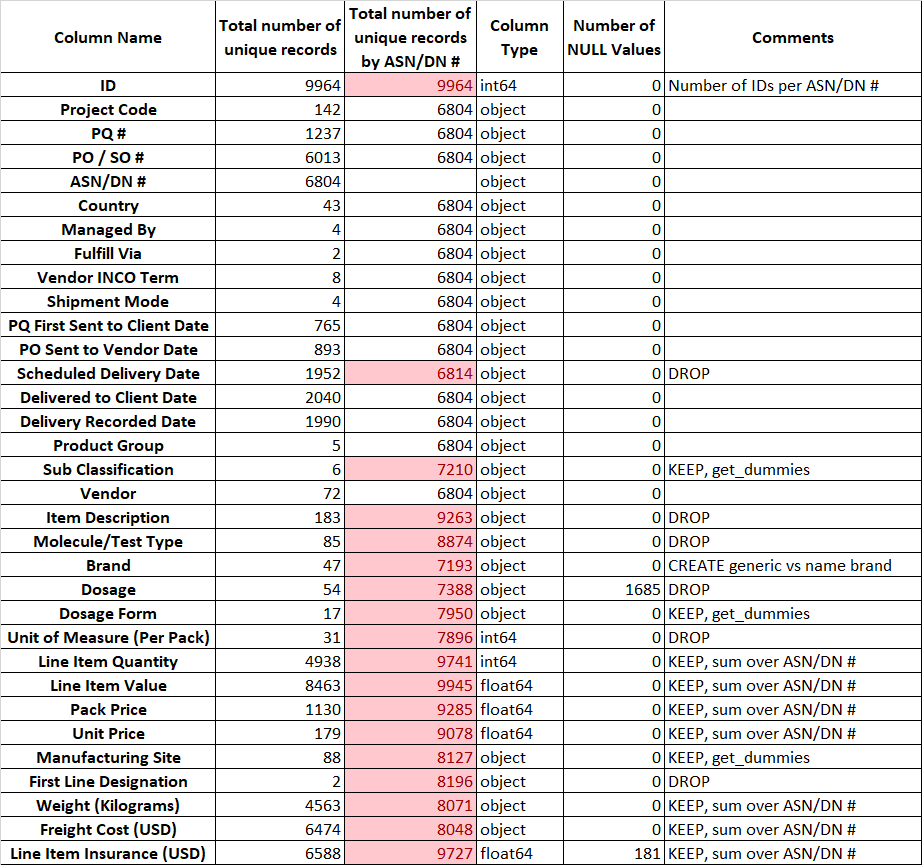

* Below indicates some of the ways that I initially summarized some of the features, but after running the model I found it was better to keep some of the features as they were and remove others. 

In [53]:
"""#Summarizing Brands into name brand and generic
df['Brand Type']=df['Brand']
for i in df.index:
    if df['Brand'][i]=='Generic':
        df['Brand Type'][i]='Generic'
    else:
        df['Brand Type'][i]='Brand'
        """
"""#Grouping the two HIV tests together
df['Sub Classification Summary']=df['Sub Classification']
for i in df.index:
    if df['Sub Classification'][i] in('HIV test - Ancillary', 'HIV test'):
        df['Sub Classification Summary'][i]='HIV'
    else:
        df['Sub Classification Summary'][i]=df['Sub Classification'][i]"""

"""#Grabbing the first word in Dosage Form 
df['Dosage Form Summary']=df['Dosage Form']
for i in df.index:
    df['Dosage Form Summary'][i]=df['Dosage Form'][i].split()[0]"""
        
"""#Grabbing the top 15 project codes and grouping everything else together
top_15_project_codes=df['Project Code'].value_counts()[:15].index.tolist()
df['Project Code Modified']=df['Project Code']
for i in df.index:
    if df['Project Code'][i] in top_15_project_codes:
        df['Project Code Modified'][i]=df['Project Code'][i]
    else:
        df['Project Code Modified'][i]='Other'"""
"""#Grouping all PQ#s that aren't Pre-PQ Processing together
df['PQ # Summary']=df['PQ #']        
for i in df.index:
    if df['PQ #'][i] =='Pre-PQ Process':
        df['PQ # Summary'][i]='Pre-PQ Process'
    else:
        df['PQ # Summary'][i]='Other'"""
"""#Grabbing the top 10 countries and grouping everything else together
top_10_countries=df['Country'].value_counts()[:10].index.tolist()
df['Country Modified']=df['Country']
for i in df.index:
    if df['Country'][i] in top_10_countries:
        df['Country Modified'][i]=df['Country'][i]
    else:
        df['Country Modified'][i]='Other Country'"""

"#Grabbing the top 10 countries and grouping everything else together\ntop_10_countries=df['Country'].value_counts()[:10].index.tolist()\ndf['Country Modified']=df['Country']\nfor i in df.index:\n    if df['Country'][i] in top_10_countries:\n        df['Country Modified'][i]=df['Country'][i]\n    else:\n        df['Country Modified'][i]='Other Country'"

* I was thinking that if the delivery is late, then that might impact the freight cost

In [54]:
from datetime import datetime
df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'])
df['Delivered to Client Date'] = pd.to_datetime(df['Delivered to Client Date'])
df['Delivery Recorded Date'] = pd.to_datetime(df['Delivery Recorded Date'])

#If it's late then it's 1, if it's on time, then it's 0
df['Late Delivery'] = 0
df['Late Delivery'].mask((df['Delivered to Client Date']-df['Scheduled Delivery Date']).dt.days > 0, 1, inplace = True)

#If freight cost or weight are non-numeric values they will be nan
df['Freight Cost (USD)']=df['Freight Cost (USD)'].apply(pd.to_numeric, errors='coerce')
df['Weight (Kilograms)']=df['Weight (Kilograms)'].apply(pd.to_numeric, errors='coerce')

In [55]:
# For now, I'm going to only drop or aggregate the columns with more that 1 value per ASN/DN #
df=df.drop(columns=['Scheduled Delivery Date', 'Item Description', 'Molecule/Test Type', 'Dosage','First Line Designation' ], axis=1)
#I need to convert some of these columns with more than 1 record per ASN/DN # into dummy variables. 
df=pd.get_dummies(df, columns=['Brand', 'Sub Classification','Dosage Form', 'Manufacturing Site'], drop_first=True)
df

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Manufacturing Site_Ranbaxy per Shasun Pharma Ltd,"Manufacturing Site_Ranbaxy, Paonta Shahib, India","Manufacturing Site_Remedica, Limassol, Cyprus",Manufacturing Site_Roche Basel,Manufacturing Site_Roche Madrid,"Manufacturing Site_Standard Diagnostics, Korea","Manufacturing Site_Strides, Bangalore, India.","Manufacturing Site_Trinity Biotech, Plc","Manufacturing Site_Weifa A.S., Hausmanngt. 6, P.O. Box 9113 GrÃ¸nland, 0133, Oslo, Norway",Manufacturing Site_bioLytical Laboratories
0,11667,151-NG-T01,Pre-PQ Process,SO-27816,DN-1350,Nigeria,PMO - US,From RDC,N/A - From RDC,Air Charter,...,0,0,0,0,0,0,0,0,0,0
1,83900,111-MZ-T30,FPQ-15195,SO-50140,DN-4191,Mozambique,PMO - US,From RDC,N/A - From RDC,Truck,...,0,0,0,0,0,0,0,0,0,0
2,86183,110-ZM-T30,FPQ-14784,SO-49621,DN-4192,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,0,0,0,0,0,0,0,0,0,0
3,83472,110-ZM-T30,FPQ-6221,SO-37340,DN-2072,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,0,0,0,0,0,0,0,0,0,0
4,86199,110-ZM-T30,FPQ-14784,SO-49622,DN-4257,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,5294,102-NG-T01,Pre-PQ Process,SCMS-228,ASN-141,Nigeria,PMO - US,Direct Drop,EXW,Air,...,0,0,0,0,0,0,0,1,0,0
10320,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,0,0,0,0,0,0,0,0,0,0
10321,5243,104-CI-T01,Pre-PQ Process,SCMS-40,ASN-26,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,0,0,0,0,0,0,0,0,0,0
10322,9269,105-GY-T01,Pre-PQ Process,SCMS-123,ASN-78,Guyana,PMO - US,Direct Drop,EXW,Air,...,0,0,0,0,0,0,0,0,0,0


# Aggregating the Data

* For the remaining columns that have more than 1 value per ASN/DN # I will aggregate it below. 
* I am going to break the DataFrame up into numeric and categorical columns. 
* The reason I am doing this is because I created dummy variables above, and I want to make sure that if there is more than 1 value for a given shipment, both dummy variables are included.
* For example, if a given shipment has 2 manufacturing sites, I want to make sure there is a 1 at both manufacturing sites when I aggregate the data by ASN/DN #. 

In [56]:
#Making lists of the columns with numeric/categorical values
numeric_columns=df.select_dtypes(['number']).columns.tolist()
categorical_columns=df.select_dtypes(['object']).columns.tolist()
#For the dummy columns I just created above: if there are multiple items in a shipment from different brands or 
#manufacturing sites, etc. I need to be able to summarize them so I can tell where each item is from in the shipment 
df2_numeric=df[numeric_columns+['ASN/DN #']].drop(columns=['Weight (Kilograms)', 'Freight Cost (USD)'], axis=1).groupby('ASN/DN #').agg(lambda x: x.max())
df2_categorical=df[categorical_columns+['Freight Cost (USD)']+['Weight (Kilograms)']].dropna(subset=['Freight Cost (USD)', 'Weight (Kilograms)']).astype(str).groupby('ASN/DN #').agg(lambda x: ','.join(x.unique()))
df2=pd.concat([df2_categorical, df2_numeric], axis=1, join='inner')

df2['Number of IDs']=df.astype(str).groupby('ASN/DN #').agg({'ID': lambda x:x.nunique()})
#df2['Number of Manufacturing Sites']=df.astype(str).groupby('ASN/DN #').agg({'Manufacturing Site': lambda x:x.nunique()})
df2['Shipment Late']=df.groupby('ASN/DN #').agg({'Late Delivery' : lambda x:x.sum()})
df2['Shipment Unit of Measure (Per Pack)']=df.groupby('ASN/DN #').agg({'Unit of Measure (Per Pack)': lambda x:x.sum()})
df2['Shipment Quantity']=df.groupby('ASN/DN #').agg({'Line Item Quantity': lambda x:x.sum()})
df2['Shipment Value']=df.groupby('ASN/DN #').agg({'Line Item Value': lambda x:x.sum()})
df2['Avg Shipment Pack Price']=df.groupby('ASN/DN #').agg({'Pack Price': lambda x:x.mean()})
df2['Avg Shipment Unit Price']=df.groupby('ASN/DN #').agg({'Unit Price': lambda x:x.mean()})
df2['Weight (Kilograms)']=pd.to_numeric(df2['Weight (Kilograms)'])
df2['Freight Cost (USD)']=pd.to_numeric(df2['Freight Cost (USD)'])
df2['Shipment Insurance']=df.groupby('ASN/DN #').agg({'Line Item Insurance (USD)': lambda x:x.sum()})
df2=df2.drop(columns=['ID', 'Unit of Measure (Per Pack)', 'Line Item Quantity', 'Line Item Value', 'Pack Price', 
                     'Unit Price', 'Line Item Insurance (USD)', 'Late Delivery'], axis=1)
df2

,Project Code,PQ #,PO / SO #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,...,"Manufacturing Site_Weifa A.S., Hausmanngt. 6, P.O. Box 9113 GrÃ¸nland, 0133, Oslo, Norway",Manufacturing Site_bioLytical Laboratories,Number of IDs,Shipment Late,Shipment Unit of Measure (Per Pack),Shipment Quantity,Shipment Value,Avg Shipment Pack Price,Avg Shipment Unit Price,Shipment Insurance
ASN/DN #,,,,,,,,,,,,,,,,,,,,,
ASN-10006,106-HT-T30,FPQ-6941,SCMS-100090,Haiti,PMO - US,Direct Drop,FCA,Air,1/3/2011,2/15/2011,...,0,0,1,0,60,200,1900.00,9.50,0.16,3.14
ASN-10007,106-HT-T30,FPQ-7066,SCMS-100140,Haiti,PMO - US,Direct Drop,FCA,Air,1/27/2011,2/15/2011,...,0,0,2,0,120,460,3970.00,8.25,0.14,6.55
ASN-10062,106-HT-T30,FPQ-7040,SCMS-98580,Haiti,PMO - US,Direct Drop,FCA,Air,1/14/2011,2/2/2011,...,0,0,1,0,100,2000,195360.00,97.68,0.98,322.34
ASN-10063,152-HT-T30,FPQ-6823,SCMS-98550,Haiti,PMO - US,Direct Drop,EXW,Air,12/14/2010,2/2/2011,...,0,0,1,0,100,33,3223.44,97.68,0.98,5.32
ASN-10064,102-GY-T30,FPQ-6983,SCMS-97160,Guyana,PMO - US,Direct Drop,EXW,Air,1/5/2011,2/2/2011,...,0,0,1,0,100,418,41800.00,100.00,1.00,68.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DN-995,114-UG-T01,Pre-PQ Process,SO-17780,Uganda,PMO - US,From RDC,N/A - From RDC,Air,Pre-PQ Process,N/A - From RDC,...,0,0,1,0,60,500,1450.00,2.90,0.05,2.84
DN-996,114-UG-T01,Pre-PQ Process,SO-17710,Uganda,PMO - US,From RDC,N/A - From RDC,Air,Pre-PQ Process,N/A - From RDC,...,0,0,1,0,60,5377,50274.95,9.35,0.16,98.54
DN-997,106-HT-T01,Pre-PQ Process,SO-15940,Haiti,PMO - US,From RDC,N/A - From RDC,Air,Pre-PQ Process,N/A - From RDC,...,0,0,1,0,240,10000,21000.00,2.10,0.01,41.16


In [57]:
#I exported this into excel again so I could load it into Tableau and determine which columns I wanted to Keep/Drop
#df2.to_excel(r'C:\Users\irifmw\Downloads\SCRATCH\Agg_Data.xlsx')

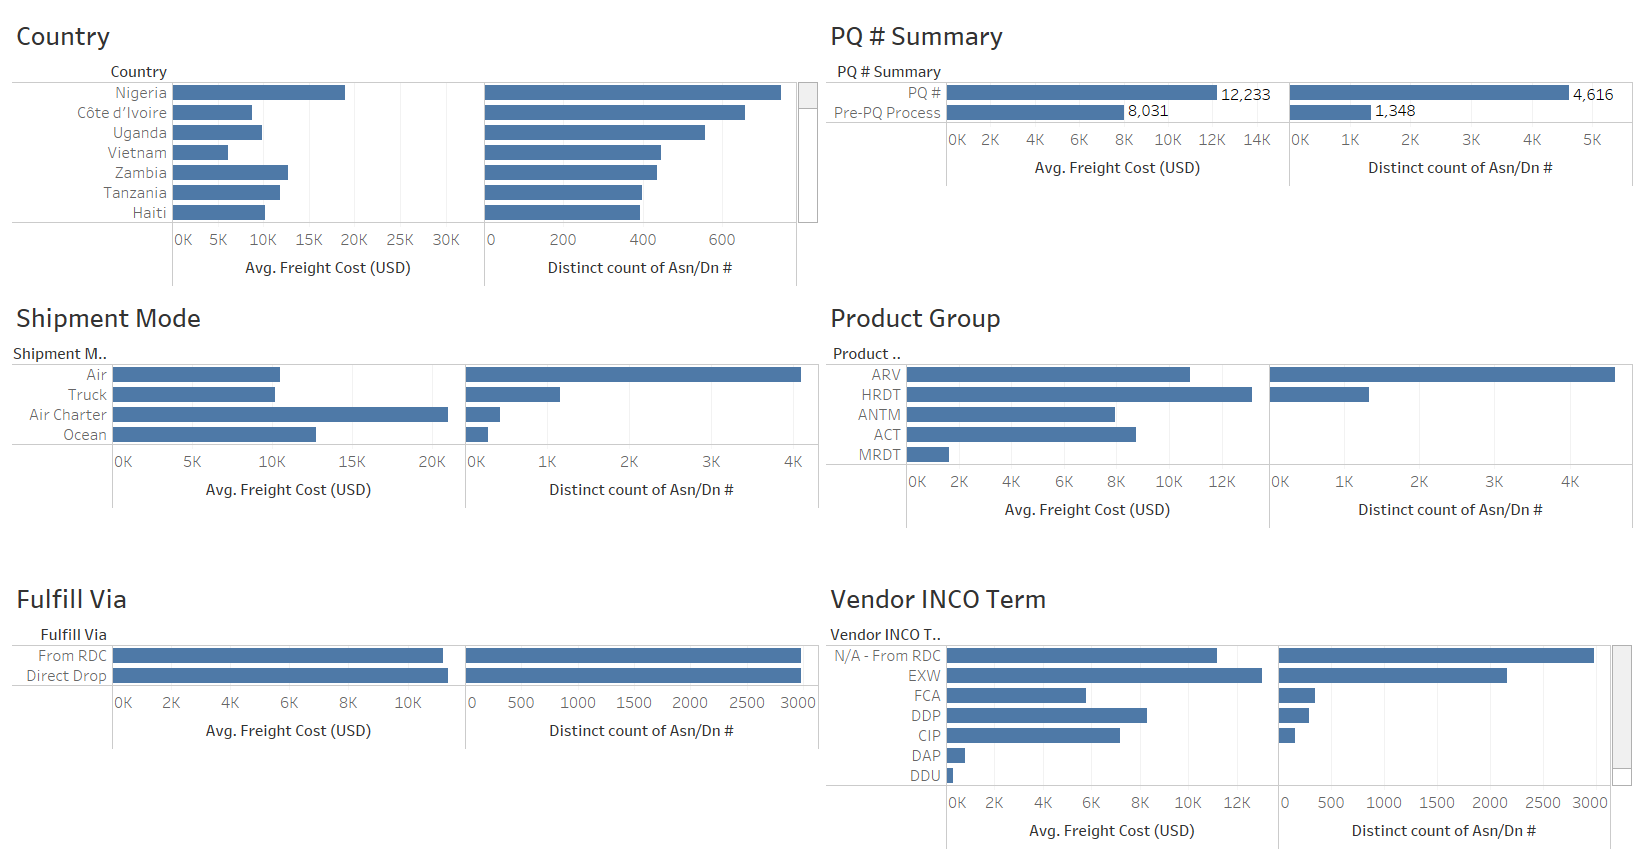

* After visualizing the data in excel and seeing which columns had a good spread for both Freight Cost and number of ASN/DN records, I decided to keep/aggregate the following. 

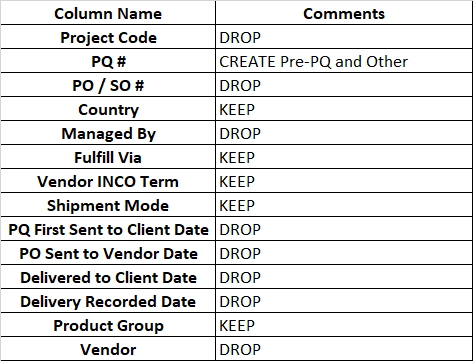

In [58]:
#Grouping all PQ#s that aren't Pre-PQ Processing together
df2['PQ # Summary']=df2['PQ #']        
for i in df2.index:
    if df2['PQ #'][i] =='Pre-PQ Process':
        df2['PQ # Summary'][i]='Pre-PQ Process'
    else:
        df2['PQ # Summary'][i]='Other'
df2['Project Code Summary']=df2['Project Code'].str[-3:]
df2=df2.drop(columns=['Project Code', 'PQ #', 'PO / SO #', 'Managed By', 'PQ First Sent to Client Date', 
                  'PO Sent to Vendor Date', 'Vendor'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5964 entries, ASN-10006 to DN-999
Columns: 171 entries, Country to Project Code Summary
dtypes: float64(6), int64(4), object(7), uint8(154)
memory usage: 1.8+ MB


In [59]:
#Dropping Weight and Freight Cost outliers
def drop_outliers(df, field_name):
    iqr=1.5*(np.percentile(df[field_name], 75)-np.percentile(df[field_name], 25))
    df.drop(df[df[field_name]>(iqr+np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name]<(np.percentile(df[field_name], 25)-iqr)].index, inplace=True)
drop_outliers(df2, 'Weight (Kilograms)')
drop_outliers(df2, 'Freight Cost (USD)')


In [60]:
"""#log transform skewed numeric features:
numeric_feats = df2.dtypes[df2.dtypes != "object"].index

skewed_feats = df2[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df2[skewed_feats] = np.log1p(df2[skewed_feats])
df2["Freight Cost (USD)"] = np.expm1(df2["Freight Cost (USD)"])
"""

'#log transform skewed numeric features:\nnumeric_feats = df2.dtypes[df2.dtypes != "object"].index\n\nskewed_feats = df2[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness\nskewed_feats = skewed_feats[skewed_feats > 0.75]\nskewed_feats = skewed_feats.index\n\ndf2[skewed_feats] = np.log1p(df2[skewed_feats])\ndf2["Freight Cost (USD)"] = np.expm1(df2["Freight Cost (USD)"])\n'

In [61]:
#Seeing how correlated the numeric values are to Freight Cost
corr_matrix = df2.corr()
target_var = "Freight Cost (USD)"
corr_matrix[target_var].apply(lambda x: abs(x)).sort_values(ascending=False)[0:20]

Freight Cost (USD)                                1.000000
Weight (Kilograms)                                0.487169
Shipment Value                                    0.448580
Shipment Insurance                                0.391329
Shipment Quantity                                 0.326930
Manufacturing Site_Alere Medical Co., Ltd.        0.231611
Brand_Determine                                   0.214047
Sub Classification_HIV test                       0.134251
Dosage Form_Test kit                              0.132132
Sub Classification_Pediatric                      0.119617
Dosage Form_Tablet - FDC                          0.113777
Manufacturing Site_ABBVIE Ludwigshafen Germany    0.086076
Brand_Norvir                                      0.076269
Dosage Form_Chewable/dispersible tablet           0.071561
Brand_OraQuick                                    0.071488
Manufacturing Site_BMS Meymac, France             0.070947
Manufacturing Site_MSD, Haarlem, NL               0.0676

In [62]:
#I saw that Weight, Shiment Value, Shipment Insurance, and Shipment Quantity were highly correlated with Freight Cost so I 
# am going to dro pthe other numeric values that I created
df2=df2.drop(columns=['Number of IDs', 'Avg Shipment Unit Price', 'Shipment Unit of Measure (Per Pack)', 
                      'Avg Shipment Pack Price', 'Shipment Late'])

In [63]:
# I am creating dummy variables for the remaining categorical columns
ship_dummies = pd.get_dummies(df2, drop_first=True)

In [64]:
X = ship_dummies.drop('Freight Cost (USD)', 1)
y = ship_dummies['Freight Cost (USD)']

### Feature Selection: KBest
* Originally I wanted to see if using a FeatureSelection method would help the model, but after some experimentation it appears that it doesn't do much for it. 

In [65]:
"""from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
# Create and fit selector 
selector = SelectKBest(mutual_info_regression, k=150)
selector.fit(X, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X = X.iloc[:,cols]"""

'from sklearn.feature_selection import SelectKBest\nfrom sklearn.feature_selection import f_regression, mutual_info_regression\n# Create and fit selector \nselector = SelectKBest(mutual_info_regression, k=150)\nselector.fit(X, y)\n# Get columns to keep and create new dataframe with those only\ncols = selector.get_support(indices=True)\nX = X.iloc[:,cols]'

* Splitting data into test/train sets

In [66]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)

* Creating a function that takes what type of model you would like to run, transforms it, then returns the training score, MAPE, R2, MSME, RMSE, and MAE along with a DataFrame that has the predicted value and the actual values for the test set. 

In [67]:
from sklearn import metrics
def predict(ml_model):
    model_trans=TransformedTargetRegressor(regressor=ml_model, 
                                           transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"))
    model=model_trans.fit(X_train,y_train)
    print('Training score : {}'.format(model.score(X_train,y_train)))
    print('\n')
    y_prediction=model.predict(X_test)
    r2_score=metrics.r2_score(y_test,y_prediction)
    print('MAPE:', mean_absolute_percentage_error(y_test,y_prediction))
    print('r2 score: {}'.format(r2_score))
    print('MSE:',metrics.mean_squared_error(y_test,y_prediction))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_prediction)))
    print('MAE:',metrics.mean_absolute_error(y_test,y_prediction))
    sns.distplot(y_test-y_prediction)
    df=pd.DataFrame(y_test, index=y_test.index)
    df['Predicted Freight Cost (USD)']=pd.DataFrame(y_prediction,index = y_test.index) 
    return df

### Random Forest Regressor

Training score : 0.9542335733078906


MAPE: 0.9093425540684188
r2 score: 0.7266267851494123
MSE: 11747805.719932891
RMSE: 3427.5072166128098
MAE: 2146.666931568816


,Freight Cost (USD),Predicted Freight Cost (USD)
ASN/DN #,,
DN-3043,3048.08,1883.003851
DN-2878,8443.89,8156.621818
ASN-10837,4204.67,4757.383109
ASN-9056,13562.35,13394.256151
ASN-1380,6687.51,5592.777355
...,...,...
ASN-5061,18459.58,14938.594912
ASN-32258,3775.50,6639.597629
ASN-28820,10203.10,8766.577672


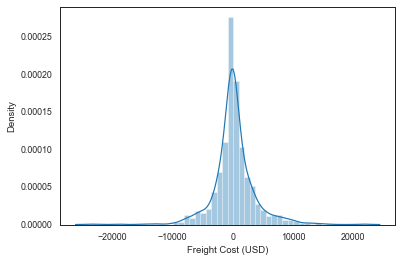

In [68]:
predict(RandomForestRegressor(n_estimators=1000, random_state = 42))

### Linear Regression

Training score : 0.4154884426306398


MAPE: 1.2699949558964727
r2 score: 0.4290474229507274
MSE: 24535834.478647895
RMSE: 4953.365974632593
MAE: 3390.576492284602


,Freight Cost (USD),Predicted Freight Cost (USD)
ASN/DN #,,
DN-3043,3048.08,3032.949141
DN-2878,8443.89,8243.675300
ASN-10837,4204.67,894.550999
ASN-9056,13562.35,9677.446877
ASN-1380,6687.51,8464.333494
...,...,...
ASN-5061,18459.58,10880.390705
ASN-32258,3775.50,6784.567525
ASN-28820,10203.10,7891.943230


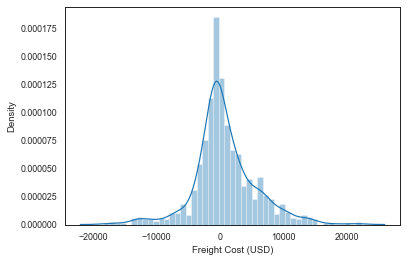

In [69]:
predict(LinearRegression())

### XGBoost

Training score : 0.912690457399522


MAPE: 0.8681228071830683
r2 score: 0.7169605367019585
MSE: 12163198.313766034
RMSE: 3487.577714369392
MAE: 2181.6822897689367


,Freight Cost (USD),Predicted Freight Cost (USD)
ASN/DN #,,
DN-3043,3048.08,2884.728516
DN-2878,8443.89,8334.251953
ASN-10837,4204.67,3789.897705
ASN-9056,13562.35,16666.378906
ASN-1380,6687.51,4691.550781
...,...,...
ASN-5061,18459.58,17183.392578
ASN-32258,3775.50,6664.320801
ASN-28820,10203.10,7953.811523


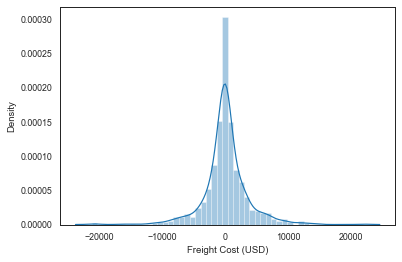

In [70]:
#XGBoost
predict(xgb.XGBRegressor())

### Hyperparameter Tuning the Best Model 

In [71]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1222,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

Training score : 0.956324350690396


MAPE: 0.9186578267953381
r2 score: 0.7312635431306201
MSE: 11548547.969083562
RMSE: 3398.315460501506
MAE: 2098.689257820937


,Freight Cost (USD),Predicted Freight Cost (USD)
ASN/DN #,,
DN-3043,3048.08,2820.260938
DN-2878,8443.89,7880.162543
ASN-10837,4204.67,4599.973494
ASN-9056,13562.35,15280.421398
ASN-1380,6687.51,5949.641645
...,...,...
ASN-5061,18459.58,18614.255597
ASN-32258,3775.50,5647.581671
ASN-28820,10203.10,8971.037201


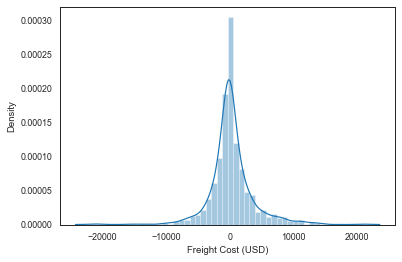

In [72]:
best_random = rf_random.best_estimator_
predict(best_random)

In [73]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [80, 90, 100, 110, 120],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [700, 800, 900, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


{'bootstrap': False,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 700}

Training score : 0.9278990536571385


MAPE: 0.9287809825499472
r2 score: 0.7195811258832217
MSE: 12050582.4066441
RMSE: 3471.3948791003454
MAE: 2151.201883301141


,Freight Cost (USD),Predicted Freight Cost (USD)
ASN/DN #,,
DN-3043,3048.08,3423.395326
DN-2878,8443.89,7846.953149
ASN-10837,4204.67,3664.657298
ASN-9056,13562.35,15981.244704
ASN-1380,6687.51,5209.648305
...,...,...
ASN-5061,18459.58,18569.179051
ASN-32258,3775.50,5242.151892
ASN-28820,10203.10,8810.890031


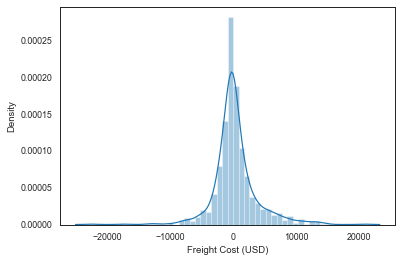

In [74]:
best_grid = grid_search.best_estimator_
predict(best_grid)

## Creating the model

In [75]:
df=pd.read_csv(r'C:\Users\irifmw\Downloads\SCRATCH\SCMS_Delivery_History_Dataset.csv')

In [81]:
def drop_outliers(df, field_name):
    iqr=1.5*(np.percentile(df[field_name], 75)-np.percentile(df[field_name], 25))
    df.drop(df[df[field_name]>(iqr+np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name]<(np.percentile(df[field_name], 25)-iqr)].index, inplace=True)
    
def aggregating(df):
    df=df.dropna(subset=['Shipment Mode'])
    df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'])
    df['Delivered to Client Date'] = pd.to_datetime(df['Delivered to Client Date'])
    df['Delivery Recorded Date'] = pd.to_datetime(df['Delivery Recorded Date'])

    #If it's late then it's 1, if it's on time, then it's 0
    df['Late Delivery'] = 0
    df['Late Delivery'].mask((df['Delivered to Client Date']-df['Scheduled Delivery Date']).dt.days > 0, 1, inplace = True)

    #If freight cost or weight are non-numeric values they will be nan
    df['Freight Cost (USD)']=df['Freight Cost (USD)'].apply(pd.to_numeric, errors='coerce')
    df['Weight (Kilograms)']=df['Weight (Kilograms)'].apply(pd.to_numeric, errors='coerce')
    # For now, I'm going to only drop or aggregate the columns with more that 1 value per ASN/DN #
    df=df.drop(columns=['Scheduled Delivery Date', 'Item Description', 'Molecule/Test Type', 'Dosage','First Line Designation' ], axis=1)
    #I need to convert some of these columns with more than 1 record per ASN/DN # into dummy variables. 
    df=pd.get_dummies(df, columns=['Brand', 'Sub Classification','Dosage Form', 'Manufacturing Site'], drop_first=True)
    #Making lists of the columns with numeric/categorical values
    numeric_columns=df.select_dtypes(['number']).columns.tolist()
    categorical_columns=df.select_dtypes(['object']).columns.tolist()
    #For the dummy columns I just created above: if there are multiple items in a shipment from different brands or 
    #manufacturing sites, etc. I need to be able to summarize them so I can tell where each item is from in the shipment 
    df2_numeric=df[numeric_columns+['ASN/DN #']].drop(columns=['Weight (Kilograms)', 'Freight Cost (USD)'], axis=1).groupby('ASN/DN #').agg(lambda x: x.max())
    df2_categorical=df[categorical_columns+['Freight Cost (USD)']+['Weight (Kilograms)']].dropna(subset=['Freight Cost (USD)', 'Weight (Kilograms)']).astype(str).groupby('ASN/DN #').agg(lambda x: ','.join(x.unique()))
    df2=pd.concat([df2_categorical, df2_numeric], axis=1, join='inner')

    df2['Number of IDs']=df.astype(str).groupby('ASN/DN #').agg({'ID': lambda x:x.nunique()})
    #df2['Number of Manufacturing Sites']=df.astype(str).groupby('ASN/DN #').agg({'Manufacturing Site': lambda x:x.nunique()})
    df2['Shipment Late']=df.groupby('ASN/DN #').agg({'Late Delivery' : lambda x:x.sum()})
    df2['Shipment Unit of Measure (Per Pack)']=df.groupby('ASN/DN #').agg({'Unit of Measure (Per Pack)': lambda x:x.sum()})
    df2['Shipment Quantity']=df.groupby('ASN/DN #').agg({'Line Item Quantity': lambda x:x.sum()})
    df2['Shipment Value']=df.groupby('ASN/DN #').agg({'Line Item Value': lambda x:x.sum()})
    df2['Avg Shipment Pack Price']=df.groupby('ASN/DN #').agg({'Pack Price': lambda x:x.mean()})
    df2['Avg Shipment Unit Price']=df.groupby('ASN/DN #').agg({'Unit Price': lambda x:x.mean()})
    df2['Weight (Kilograms)']=pd.to_numeric(df2['Weight (Kilograms)'])
    df2['Freight Cost (USD)']=pd.to_numeric(df2['Freight Cost (USD)'])
    df2['Shipment Insurance']=df.groupby('ASN/DN #').agg({'Line Item Insurance (USD)': lambda x:x.sum()})
    df2=df2.drop(columns=['ID', 'Unit of Measure (Per Pack)', 'Line Item Quantity', 'Line Item Value', 'Pack Price', 
                         'Unit Price', 'Line Item Insurance (USD)', 'Late Delivery'], axis=1)
    #Grouping all PQ#s that aren't Pre-PQ Processing together
    df2['PQ # Summary']=df2['PQ #']        
    for i in df2.index:
        if df2['PQ #'][i] =='Pre-PQ Process':
            df2['PQ # Summary'][i]='Pre-PQ Process'
        else:
            df2['PQ # Summary'][i]='Other'
    df2['Project Code Summary']=df2['Project Code'].str[-3:]
    df2=df2.drop(columns=['Project Code', 'PQ #', 'PO / SO #', 'Managed By', 'PQ First Sent to Client Date', 
                      'PO Sent to Vendor Date', 'Vendor'])
    drop_outliers(df2, 'Weight (Kilograms)')
    drop_outliers(df2, 'Freight Cost (USD)')
    #I saw that Weight, Shiment Value, Shipment Insurance, and Shipment Quantity were highly correlated with Freight Cost so I 
    # am going to dro pthe other numeric values that I created
    df2=df2.drop(columns=['Number of IDs', 'Avg Shipment Unit Price', 'Shipment Unit of Measure (Per Pack)', 
                          'Avg Shipment Pack Price', 'Shipment Late'])


    return df2


def model(df):
# I am creating dummy variables for the remaining categorical columns
    dummies = pd.get_dummies(df, drop_first=True)
    X = dummies.drop('Freight Cost (USD)', 1)
    scaler = StandardScaler()
    X_scaler=scaler.fit_transform(X)
    y = dummies['Freight Cost (USD)']
    X_train,X_test,y_train,y_test = train_test_split(X_scaler,y, test_size = 0.20, random_state = 42)
#Random Forest Regressor
    rfreg=RandomForestRegressor(n_estimators=1000, random_state=42)
#    rfreg.fit(X_train, y_train)
    rf=RandomForestRegressor(n_estimators=1000, random_state=42)
    rf_trans=TransformedTargetRegressor(regressor=rf, transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"))
    rf_trans.fit(X_train, y_train)
    pred_rfreg=rf_trans.predict(X_test)
    mape_rfreg = mean_absolute_percentage_error(y_test,pred_rfreg)
    r2_rfreg = r2_score(y_test,pred_rfreg)
    MSE_rfreg=mean_squared_error(y_test, pred_rfreg)
    RMSE_rfreg=math.sqrt(mean_squared_error(y_test, pred_rfreg))
    MAE_rfreg=mean_absolute_error(y_test, pred_rfreg)
    print('RandomForestRegressor MAPE=', mape_rfreg)
    print('RandomForestRegressor R2=', r2_rfreg)
    print('RandomForestRegressor MSE=', MSE_rfreg)
    print('RandomForestRegressor RMSE=', RMSE_rfreg)
    print('RandomForestRegressor MAE=', MAE_rfreg)
#Linear Regression
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    pred_lr = lr.predict(X_test)
    mape_lr = mean_absolute_percentage_error(y_test,pred_lr)
    r2_lr = r2_score(y_test,pred_lr)
    MSE_lr=mean_squared_error(y_test, pred_lr)
    RMSE_lr=math.sqrt(mean_squared_error(y_test, pred_lr))
    MAE_lr=mean_absolute_error(y_test, pred_lr)
    print('LinearRegression MAPE=', mape_lr)
    print('LinearRegression R2=', r2_lr)
    print('LinearRegression MSE=', MSE_lr)
    print('LinearRegression RMSE=', RMSE_lr)
    print('LinearRegression MAE=', MAE_lr)
#XGBoost
    xg_reg = xgb.XGBRegressor()
    xg_reg.fit(X_train,y_train)
    pred_xgb = xg_reg.predict(X_test)
    mape_xgb = mean_absolute_percentage_error(y_test,pred_xgb)
    r2_xgb = r2_score(y_test,pred_xgb)
    MSE_xgb=mean_squared_error(y_test, pred_xgb)
    RMSE_xgb=math.sqrt(mean_squared_error(y_test, pred_xgb))
    MAE_xgb=mean_absolute_error(y_test, pred_xgb)
    print('XGBoost MAPE=', mape_xgb)
    print('XGBoost R2=', r2_xgb)
    print('XGBoost MSE=', MSE_xgb)
    print('XGBoost RMSE=', RMSE_xgb)
    print('XGBoost MAE=', MAE_xgb)
    df=pd.DataFrame(y_test, index=y_test.index)
    df['Predicted Freight Cost (USD)']=pd.DataFrame(pred_rfreg,index = y_test.index) 
    return df


In [82]:
df_agg=aggregating(df)
model(df_agg)

RandomForestRegressor MAPE= 0.9092227662293033
RandomForestRegressor R2= 0.7267203628335802
RandomForestRegressor MSE= 11743784.358681655
RandomForestRegressor RMSE= 3426.9205357991095
RandomForestRegressor MAE= 2144.399970937315
LinearRegression MAPE= 14016682335384.615
LinearRegression R2= -1.1559042702564275e+27
LinearRegression MSE= 4.967326007134645e+34
LinearRegression RMSE= 2.2287498754087782e+17
LinearRegression MAE= 1.2237720828246788e+16
XGBoost MAPE= 1.1717878431960678
XGBoost R2= 0.7020512412256791
XGBoost MSE= 12803903.024987042
XGBoost RMSE= 3578.2541867490413
XGBoost MAE= 2300.477936852219


,Freight Cost (USD),Predicted Freight Cost (USD)
ASN/DN #,,
DN-3043,3048.08,1887.827498
DN-2878,8443.89,8140.439560
ASN-10837,4204.67,4687.370521
ASN-9056,13562.35,13398.045703
ASN-1380,6687.51,5575.000908
...,...,...
ASN-5061,18459.58,14919.701302
ASN-32258,3775.50,6668.434721
ASN-28820,10203.10,8766.028302
